In [15]:
from pathlib import Path
import geopandas as gpd

from GDRT.raster.register_images import align_two_rasters
from GDRT.raster.registration_algorithms import cv2_feature_matcher
from GDRT.raster.utils import update_transform
from GDRT.constants import DATA_FOLDER

In [16]:
FIXED_ORTHO_FILENAME = Path(DATA_FOLDER, "orthomosaic_580.tif")
MOVING_ORTHO_FILENAME = Path(DATA_FOLDER, "orthomosaic_921.tif")

ROI_FILE = Path(DATA_FOLDER, "ROI.gpkg")

SHIFTED_ORTHO_FILENAME = Path(DATA_FOLDER, "orthomosaic_921_shifted.tif")

BUFFER_METERS = 50
TARGET_GSD = 0.1

/ofo-share/repos-david/geospatial-data-registration-toolkit/GDRT/raster/register_images.py:86: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if region_of_interest.area.sum() == 0:


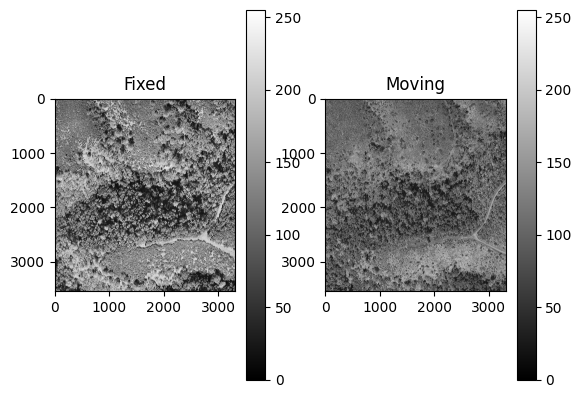

Updating most inliers to be 0
Final number of inliears is 1


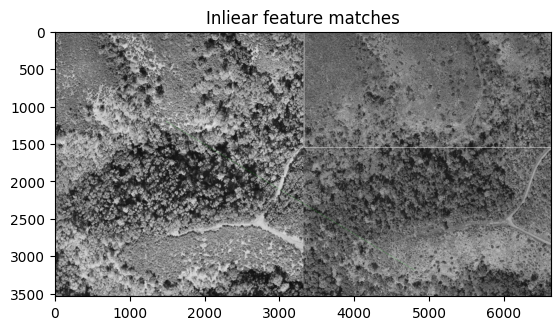

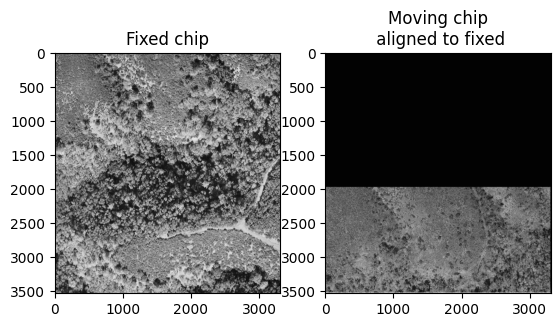

In [ ]:
ROI = gpd.read_file(ROI_FILE)
ROI = ROI.dissolve()

transforms = align_two_rasters(
    FIXED_ORTHO_FILENAME,
    MOVING_ORTHO_FILENAME,
    aligner_alg=cv2_feature_matcher,
    region_of_interest=ROI,
    target_GSD=TARGET_GSD,
    vis_chips=True,
)

In [18]:
update_transform(
    MOVING_ORTHO_FILENAME,
    SHIFTED_ORTHO_FILENAME,
    relative_transform=transforms["geospatial_mv2fx_transform"],
    update_existing=True,
)